In [1]:
# Install required packages from requirements.txt
%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/73.6 MB 6.1 MB/s eta 0:00:11

In [2]:
from matplotlib import gridspec
from IPython.display import Image
import os
import joblib
from datetime import datetime
import os, joblib
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import xgboost as xgb
from os.path import join
from scipy.ndimage import label
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path

In [42]:
# Form the paths for different files
BASE_DIR = Path.cwd()

# Define a figures directory
FIGURES_DIR = BASE_DIR / "data"/ "figures"

# Define a models directory
MODELS_DIR = BASE_DIR / "data"/ "models"

# Define testing data directory
TEST_DIR = BASE_DIR / "data"/ "test"

# Define a training directory
TRAIN_DIR = BASE_DIR / "data"/ "training"

# I-GUIDE Summer School 2025 - Team 2
# GeoAI for Burn Area Analysis and Fire Risk Mapping in the Pantanal Wetlands

## Introduction

In June 2024, the Pantanal wetlands—a UNESCO World Heritage site and one of the planet’s most biodiverse ecosystems—experienced a wildfire crisis of unprecedented scale. Over 1.3 million hectares burned, an area more than eight times the size of London, marking the most severe early-season fire activity on record.

This disaster was driven by the convergence of extreme drought, strong winds, and land-use changes such as pasture expansion. Climate change amplified the event, increasing fire intensity by ~40% and making such extreme events 4–5 times more likely.

The impacts were severe:
- Wildlife deaths and habitat destruction in one of Earth’s richest ecosystems
- Respiratory health impacts in vulnerable populations, especially children and the elderly
- Loss of agricultural productivity and damage to infrastructure
- With 85% of burned areas on private lands, local livelihoods were directly affected

Looking ahead, projections indicate a hotter, drier Pantanal, with Daily Severity Rating (DSR) values ~40% higher, making wildfires harder to suppress and more likely to spread rapidly. Severe fire weather is becoming the new normal—demanding innovative, predictive tools for early warning, resource allocation, and long-term adaptation.

## Project Goal

We aim to develop a GeoAI-powered system to map and predict wildfire burn areas in the Pantanal wetlands, integrating multi-source datasets—remote sensing, climate reanalysis, and land-use data—to answer two key questions:
1. How do environmental and land-use factors influence burn extent?
2. Can GeoAI enhance early-stage fire risk mapping to support proactive management?

## Datasets

- Burn Area – [MODIS MCD64A1 v6.1](https://modis.gsfc.nasa.gov/data/dataprod/mod45.php) (downloaded from NASA AppEEARS), 500 m, high-confidence burns
- Land Cover – [ESA WorldCover](https://www.arcgis.com/home/item.html?id=cfcb7609de5f478eb7666240902d4d3d) (downloaded from ArcGIS Living Atlas), annual 2017–2024
- Elevation – [NASADEM](https://www.earthdata.nasa.gov/data/catalog/lpcloud-nasadem-hgt-001), 30 m resolution (downloaded from NASA EarthDataSearch)
- Climate Variables – [ERA5-Land hourly reanalysis](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview): temperature, dewpoint, precipitation, U/V wind, soil moisture, surface pressure (downloaded from the Copernicus Climate Change Service)
- Previous Burn History – Lag features (0–5 days) derived from MODIS burn date using a 5×5 spatial kernel to capture local fire memory  
- Earth Observation Embeddings – [Google/AlphaEarth Satellite Embeddings V1](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_SATELLITE_EMBEDDING_V1_ANNUAL) (downloaded via Google Earth Engine), enriched with mean, min, max, and std statistics across bands for enhanced spatial–temporal context  

## Study region and time frame

- Start Date: 05-01-2024; End Date: 07-31-2024
- North: -13°, West: -61°, South: -24°, East: -52°

# Step 1: Background & Data Preprocessing

- Pantanal 2024 wildfire timeline with key statistics (area burned, severity, impacts)  
- Maps of study region and fire extent (study boundary, major rivers, protected areas)  
- Dataset previews:  
  - **MODIS Burn Area (MCD64A1 v6.1)** — daily burned pixels  
  - **ESA WorldCover** — annual land-cover categories  
  - **NASADEM** — elevation and terrain  
  - **ERA5-Land** — climate variables (temperature, precipitation, soil moisture, wind, pressure)  
- Spatial and temporal patterns: time series plots, heatmaps, and maps showing seasonal trends in fire occurrence  
- Burn history extraction and **lag feature creation** (e.g., previous 1–5 days of burn activity)  
- Satellite **embedding preprocessing** (mean, min, max, std bands) for richer spatial context  
- Export of cleaned and harmonized datasets for downstream modeling


# Step 2: Burn Occurence Modeling

**Problem Setup**

For the baseline, we treat each pixel–day record as an independent sample rather than as part of a spatiotemporal sequence.

- Target variable: Burn occurrence (burn = 1 if pixel burned on that day, else 0)
- Features: Environmental, climatic, and land-use variables aggregated at the pixel level
- Assumption: No explicit temporal dependence — the model learns from correlations between conditions and burn occurrence

This approach provides a quick benchmark for predictive performance before moving to sequence-based deep learning (e.g., ConvLSTM).

**Training Data**
- Positive samples: Pixels labeled as burned (from MODIS MCD64A1 high-confidence detections)
- Negative samples: Pixels with no burn activity on the same date
- Sampling strategy: Class imbalance is severe (burn : non-burn ≈ 1 : 100), so we:
    - Use stratified sampling to limit the number of non-burn samples per burn sample
    - We apply class weights in the loss function

 **Model Choice**

Our approach focuses on understanding how different feature sets influence predictive power for burn occurrence. We compare three interpretable classifiers:  

- **Random Forest (RF)** – Captures nonlinear relationships and provides clear feature importance rankings.  
- **XGBoost** – A gradient boosting approach that often improves performance on structured datasets.  
- **TabNet** – A deep tabular learning model that leverages attention to identify important features while remaining interpretable.  

 **Purpose of Comparison**
- **Feature-driven narrative** – Shift focus from achieving the highest possible accuracy to understanding how each feature set contributes to model performance.  
- **Model diversity** – Evaluate tree-based (RF, XGBoost) and deep learning (TabNet) approaches under the same conditions.  
- **Progressive feature integration** – Assess models across three datasets:  
  1. **Basic Features (BF)** – Core environmental and climatic variables:  
     `['land_cover', 'dem', 't2m', 'd2m', 'u10', 'v10', 'tp', 'swvl1', 'sp']`  
  2. **BF + Previous Burn History (PBH)** – Adds pixel-level burn history using a 5×5 kernel.  
  3. **BF + PBH + AlphaEarth Embeddings (AE)** – Incorporates high-dimensional Earth observation embeddings for richer spatial-temporal context.  
- **Cross-model evaluation** – Compare RF, XGBoost, and TabNet across all three feature sets to determine which features most improve predictive skill and how performance trends vary by model type.  



![Baseline Modeling](data/figures/baseline.png)

**Figure 1.** Baseline modeling framework for tabular prediction of burn occurrence.  
Three feature sets are compared: 

(1) Basic environmental and climate variables,  
(2) Basic features + previous burn history derived from a 5×5 kernel, and  
(3) Basic features + previous burn history + AlphaEarth embeddings, which add  
spectral–temporal context from satellite data.


## Burn Occurence Modeling

### Training

**Table 1.** Baseline model performance comparison across three feature sets: Basic, Basic + Previous Burn History, and Basic + Previous Burn History + AlphaAI embeddings, using Random Forests, XGBoost, and TabNet as modeling frameworks. Metrics shown are Precision, Recall, and F1-score on 30% test data.

![Burn Occurrence Results](data/figures/Burn_Occurence_Results.jpg)

**Table 1.** shows the baseline modeling results for burn occurrence prediction using three feature sets: basic environmental variables, basic features plus previous burn history, and basic features plus previous burn history with AlphaEarth embeddings. Performance is evaluated with precision, recall, and F1-score on 30% test data. Results indicate that adding previous burn history improves recall and F1, while incorporating AlphaEarth embeddings further enhances performance across all models. XGBoost consistently outperforms Random Forests and TabNet, achieving the highest scores, with an F1 of 0.97 when embeddings are included.

**Table 2.** Baseline model performance comparison across three feature sets—Basic, Basic + Previous Burn History, and Basic + Previous Burn History + AlphaAI embeddings—using Random Forests, XGBoost, and TabNet. Metrics shown are Precision, Recall, and F1-score on a single day application cropped to the largest detected burn cluster.

![Burn Occurrence Results SDA](data/figures/Burn_Occurence_Results_SDA.jpg)

 **Table 2** presents single-day accuracy (June 16, 2024). Here, the models achieve very high recall (up to 0.98 for XGBoost) but with low precision and F1-scores. This suggests that while the models are sensitive to detecting fires, they also overpredict burn occurrence, leading to many false positives when applied to a single-day context.

 Together, these results highlight a key tradeoff: the models perform strongly on stratified datasets (Table 1), but when tested in real-world daily conditions (Table 2), they tend to sacrifice precision for recall.

### Application

In [35]:
# Model filename
model_fname = MODELS_DIR / "xgboost_model_with_burn_embeddings.pkl"

if os.path.exists(model_fname):
    model = joblib.load(model_fname)
    print("Model loaded successfully.")
else:
    print(f"Model file not found: {model_fname}")

Model loaded successfully.


/opt/anaconda3/lib/python3.12/pickle.py:1710: UserWarning: [16:32:13] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


166 6546
Accuracy: 0.9985182840945994
Precision: 0.0614115490375802
Recall: 0.17395067070532236
F1 Score: 0.09077565767189794


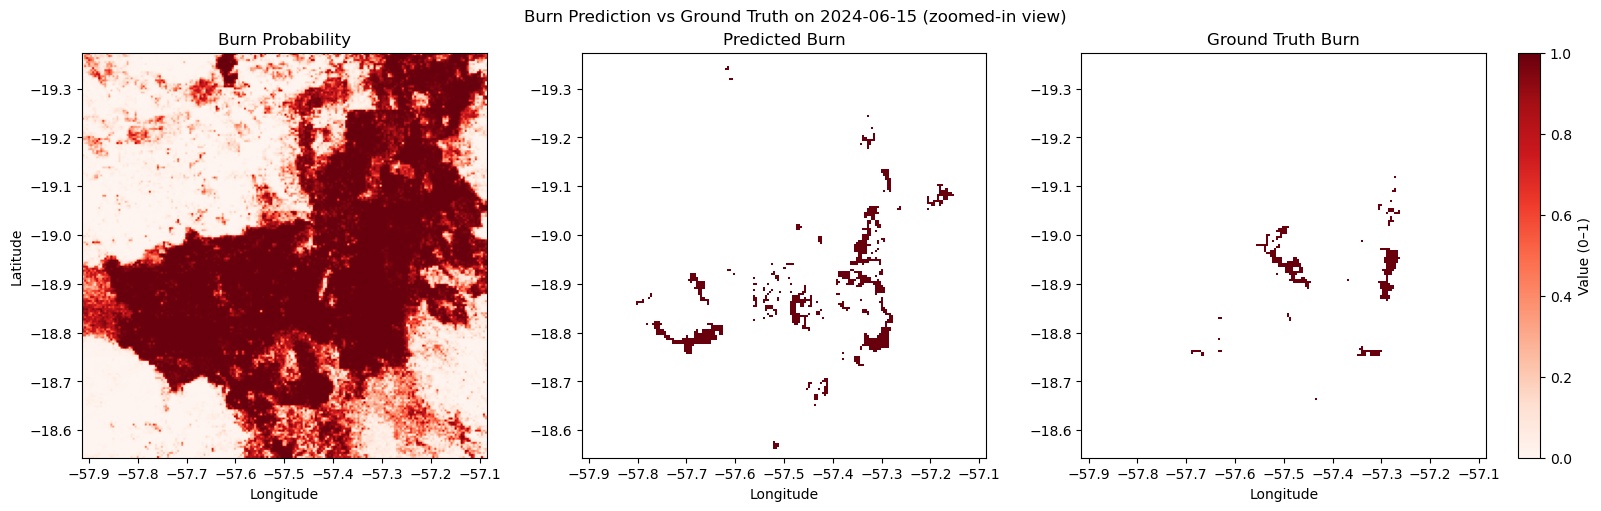

167 7399
Accuracy: 0.9985341077091362
Precision: 0.06811731315042574
Recall: 0.3197969543147208
F1 Score: 0.11231197771587743


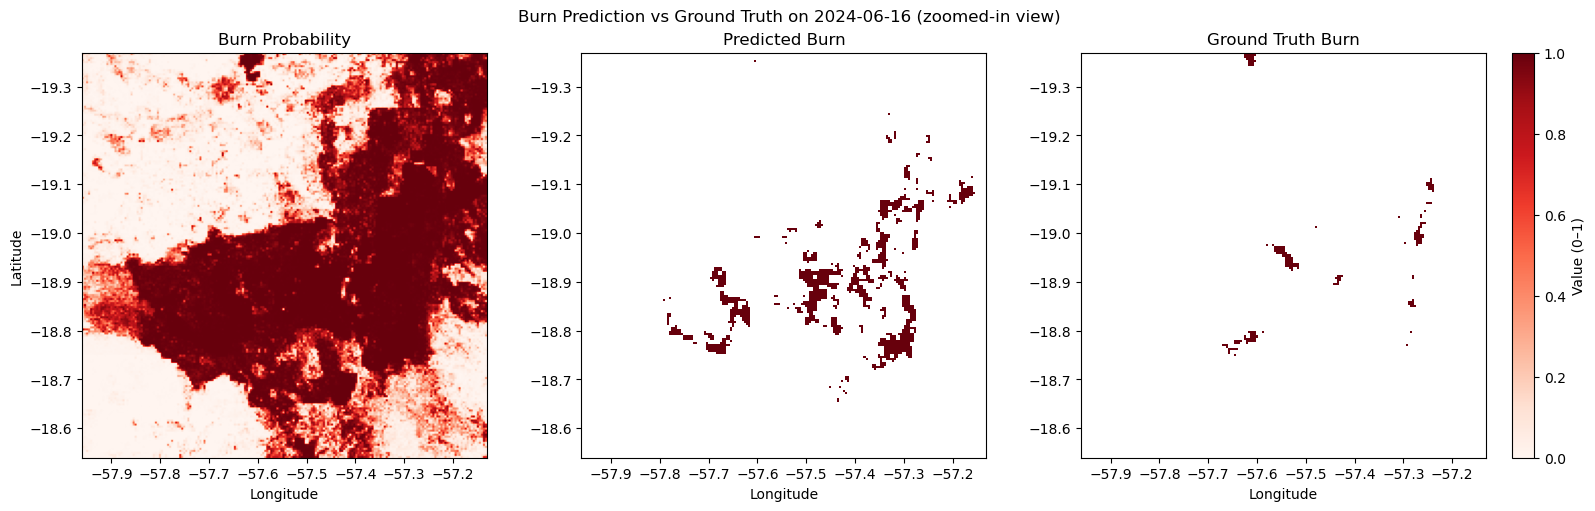

168 5856
Accuracy: 0.9987917014341531
Precision: 0.04644808743169399
Recall: 0.21673306772908366
F1 Score: 0.07650119533117705


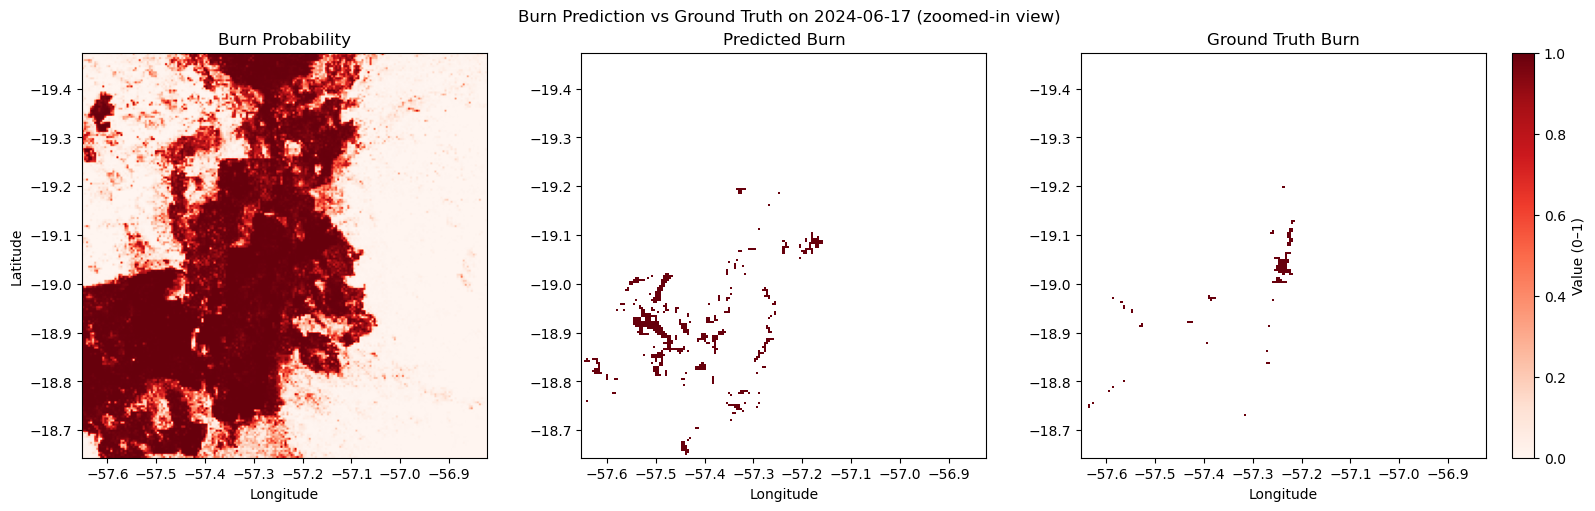

169 8866
Accuracy: 0.9982224193018658
Precision: 0.03327317843446876
Recall: 0.21299638989169675
F1 Score: 0.05755536045263877


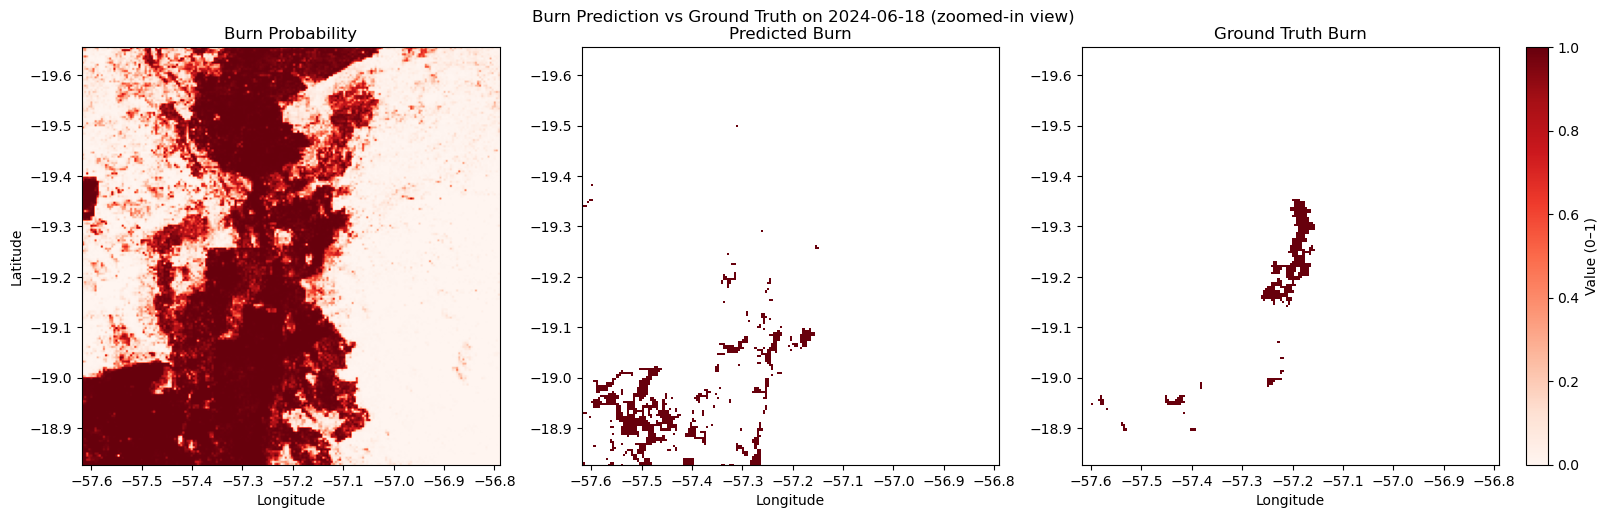

170 6036
Accuracy: 0.9987438625995071
Precision: 0.0667660702451955
Recall: 0.25234815278647466
F1 Score: 0.1055941307480676


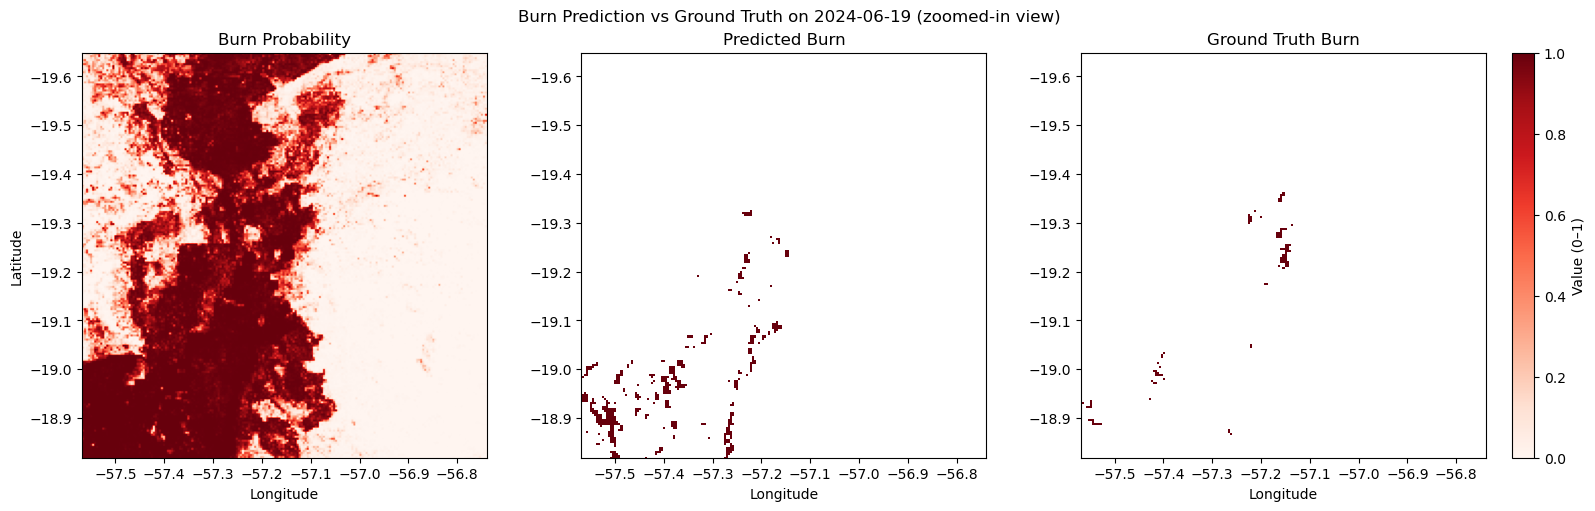

In [40]:
y_column = "burn"
prob_threshold = 0.999
model = model
for doy in range(166,171):
    target_file = TEST_DIR / f"data_{doy}.parquet"
    target_date = datetime.strptime(f"{2024}-{doy+1}", "%Y-%j").date()
    
    # Read one day's data
    df_full  = pd.read_parquet(target_file)
    df_pred = df_full.copy() #.dropna(subset=x_columns + [y_column])

    X_pred = df_pred.drop(columns=[y_column, "lag_0"])
    y_true = df_pred[y_column].values

    # pred
    y_prob = model.predict_proba(X_pred)[:, 1]
    y_pred = (y_prob > prob_threshold).astype(int)

    print(doy, np.sum(y_pred))
    
    if np.sum(y_pred) > 5:    
    
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred))
        print("Recall:", recall_score(y_true, y_pred))
        print("F1 Score:", f1_score(y_true, y_pred))

        # df to grid
        lats = np.sort(df_full['lat'].unique())
        lons = np.sort(df_full['lon'].unique())
        H, W = len(lats), len(lons)

        lat_to_idx = {lat: i for i, lat in enumerate(lats)}
        lon_to_idx = {lon: i for i, lon in enumerate(lons)}

        burn_prob_image = np.full((H, W), np.nan)
        burn_pred_image = np.full((H, W), np.nan)
        burn_true_image = np.full((H, W), np.nan)

        for k, row in enumerate(df_pred.itertuples()):
            i = lat_to_idx[row.lat]
            j = lon_to_idx[row.lon]
            burn_prob_image[i, j] = y_prob[k]
            burn_pred_image[i, j] = y_pred[k]
            burn_true_image[i, j] = y_true[k]
            
        mask = burn_true_image > prob_threshold

        # Find connected components
        structure = np.ones((3, 3))  # 8-connectivity
        labeled_array, num_features = label(mask, structure=structure)

        # Count pixels in each component
        sizes = np.bincount(labeled_array.ravel())
        sizes[0] = 0  # background = 0

        # Find the label of the largest component
        largest_label = sizes.argmax()

        # Mask to keep only the largest cluster
        largest_cluster_mask = labeled_array == largest_label

        # Get bounding box of this cluster
        rows, cols = np.where(largest_cluster_mask)

        center_row = int(np.mean(rows))
        center_col = int(np.mean(cols))

        crop_size = 200
        half_crop = crop_size // 2

        # Ensure the window stays within bounds
        row_min = max(center_row - half_crop, 0)
        row_max = min(center_row + half_crop, burn_prob_image.shape[0])
        col_min = max(center_col - half_crop, 0)
        col_max = min(center_col + half_crop, burn_prob_image.shape[1])

        burn_prob_crop = burn_prob_image[row_min:row_max, col_min:col_max]
        burn_pred_crop = burn_pred_image[row_min:row_max, col_min:col_max]
        burn_true_crop = burn_true_image[row_min:row_max, col_min:col_max]
        
        burn_pred_image[burn_pred_image<1] = np.nan
        burn_true_crop[burn_true_crop<1] = np.nan

        lat_crop = lats[row_min:row_max]
        lon_crop = lons[col_min:col_max]

        fig = plt.figure(figsize=(16, 5), constrained_layout=True)
        gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], figure=fig)

        # Create first axis normally
        axs0 = fig.add_subplot(gs[0])
        # Share y with axs0
        axs1 = fig.add_subplot(gs[1], sharey=axs0)
        axs2 = fig.add_subplot(gs[2], sharey=axs0)
        axs = [axs0, axs1, axs2]

        # Colorbar axis
        cax = fig.add_subplot(gs[3])

        vmin, vmax = 0.0, 1.0

        # Burn probability
        cmap = plt.cm.Reds
        im0 = axs[0].imshow(burn_prob_crop, cmap=cmap, vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]])
        axs[0].set_title("Burn Probability")
        axs[0].set_xlabel("Longitude")
        axs[0].set_ylabel("Latitude")

        # Predicted burn
        im1 = axs[1].imshow(burn_pred_crop, cmap=cmap, vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]])
        axs[1].set_title("Predicted Burn")
        axs[1].set_xlabel("Longitude")

        # Ground truth
        im2 = axs[2].imshow(burn_true_crop, cmap=cmap, vmin=vmin, vmax=vmax,
                            extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]])
        axs[2].set_title("Ground Truth Burn")
        axs[2].set_xlabel("Longitude")

        # Shared colorbar
        cbar = fig.colorbar(im2, cax=cax)
        cbar.set_label("Value (0–1)")

        fig.suptitle(f"Burn Prediction vs Ground Truth on {target_date} (zoomed-in view)")
        plt.show()

**Figures 2–6.** Daily burn prediction results from June 15–19, 2024. Each row shows (left) the full-scene burn probability map, (center) the predicted burn mask at >50% probability cropped to the largest burn cluster, and (right) the corresponding ground truth burn extent over the same area. These visualizations illustrate how the model captures the general location of large fire clusters but often overpredicts their extent, consistent with its high recall and lower precision on single-day evaluations.


These figures (Figures 2–6, June 15–19, 2024) illustrate how the model tracks fire progression over multiple days. The burn probability maps reveal broad areas of elevated risk, indicating the model’s sensitivity to environmental and historical fire conditions. When cropped to the largest burn cluster, the predicted masks highlight the model’s ability to detect the presence of fire activity but also expose systematic biases: the predicted burn scars are generally larger and more fragmented than the observed ground truth. This pattern reflects the model’s high recall; effectively capturing where fires are likely—but also its tendency to overpredict, producing false positives that lower precision. The day-to-day progression shows that while the model successfully follows the shifting spatial footprint of fires, it struggles to constrain burn extent with the same precision as the satellite-detected observations, underscoring the challenge of balancing early detection with spatial accuracy in wildfire prediction.

### Interpretation

In [44]:
data = pd.read_parquet(TRAIN_DIR / "training_whole.parquet")#data = data[~data.index.get_level_values("doy").isin(test_doys)]
basic_cols = ['lon', 'lat', 'land_cover', 'dem', 't2m', 'd2m', 'u10', 'v10', 'tp', 'swvl1', 'sp']
burn_cols = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
embed_cols = data.columns[data.columns.str.contains("band|embed")].to_list()
target = "burn"
cols = basic_cols+burn_cols+embed_cols


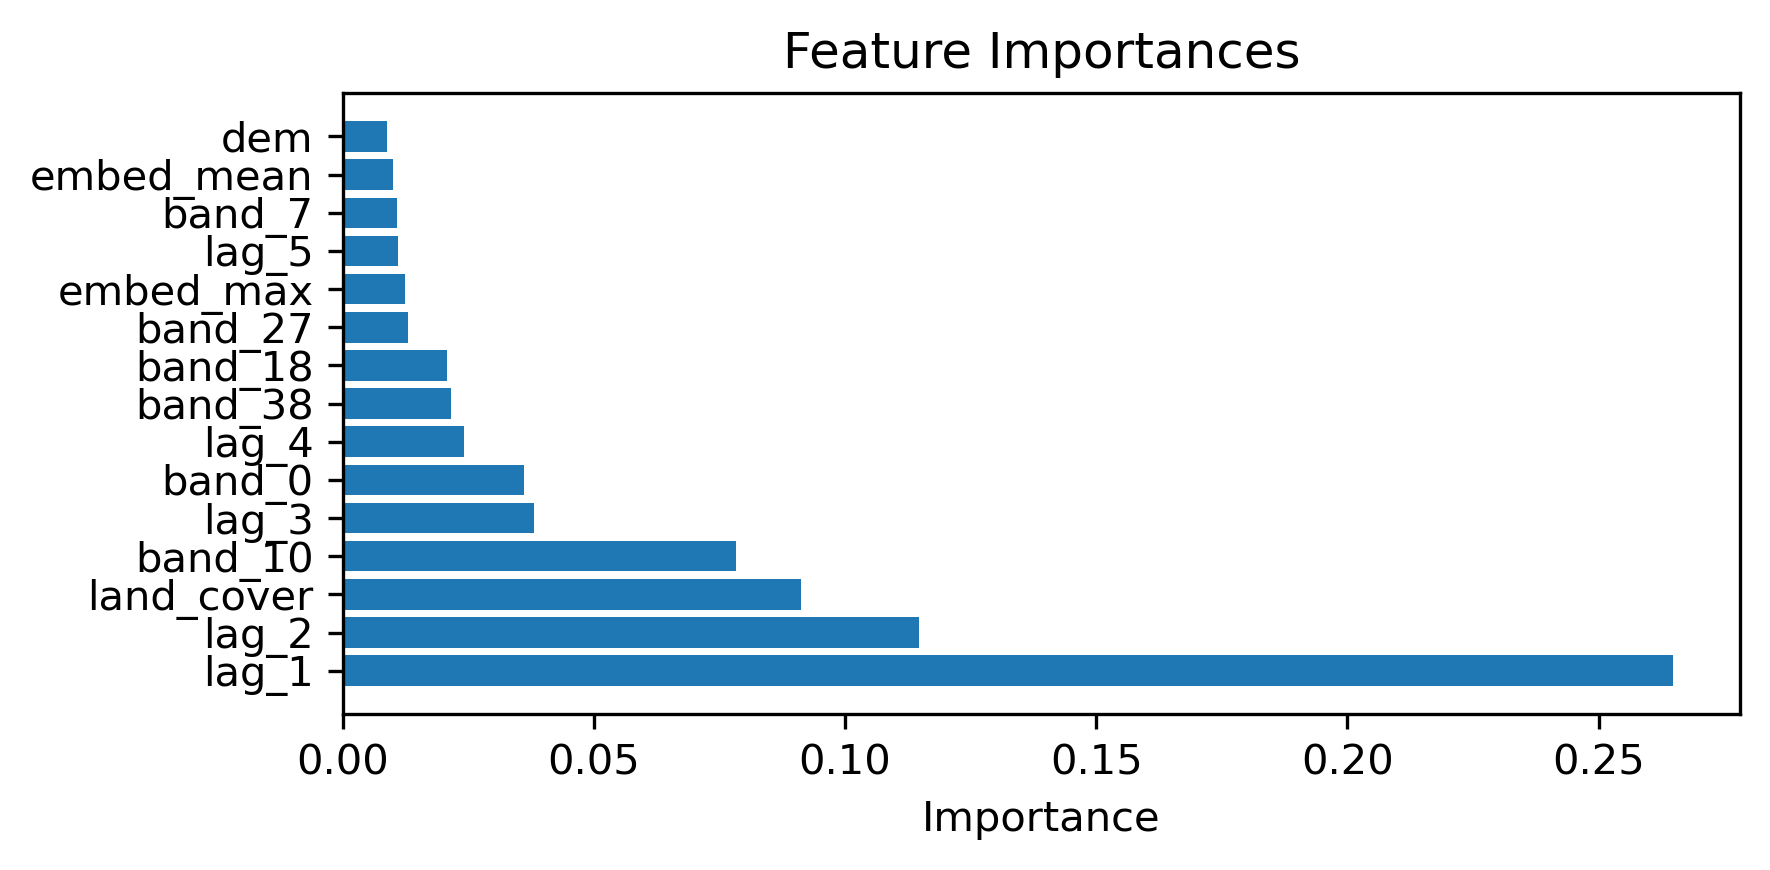

In [45]:
model = model
# Compute feature importances
feature_importances = pd.Series(
    model.feature_importances_,
    index=cols
).sort_values(ascending=True)  # ascending=True for better horizontal plot

feature_imp = pd.DataFrame(data={"Features":feature_importances.index, "Importance":feature_importances.values})
feature_imp = feature_imp.sort_values("Importance", ascending=False).head(17)
feature_imp = feature_imp[~feature_imp["Features"].isin(["lat", "lon"])]

# Plot
plt.figure(figsize=(6,3),dpi=300)
plt.barh(feature_imp["Features"], feature_imp["Importance"])
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()


This feature importance plot highlights the key drivers of burn occurrence prediction when combining baseline features, previous burn history, and AlphaEarth embeddings. The results show that recent burn history (lag_1, lag_2, lag_3) is the strongest predictor, emphasizing the role of fire memory in driving future burn activity. Land cover also plays a significant role, reflecting how vegetation type and land use influence fire risk. Among embedding-derived variables, certain spectral bands (e.g., band_10, band_0, band_38) provide additional predictive value, while elevation (dem) and embedding summary statistics contribute marginally. Overall, the analysis demonstrates that both short-term burn history and landscape context are critical for accurate wildfire modeling.


# Step 3: Residual ConvLSTM for Spatiotemporal Prediction

While the baseline model in Step 2 treats each pixel–day observation independently, wildfires are inherently spatiotemporal phenomena. Burn likelihood depends not only on the current environmental state but also on recent fire activity, weather patterns, and spatial continuity of fuels.

**Problem Setup**

In this step, we formulate the problem as a **spatiotemporal sequence classification task**:

$$
\hat{y} = f_\theta \big( X_{t-T+1}, X_{t-T+2}, \dots, X_t \big)
$$

Where:

* $X_t$ = Multichannel raster patch centered on the target pixel for day $t$
* $T$ = Number of past days used as context (sequence length)
* $\hat{y}$ = Predicted probability that the central pixel will burn on the next day ($t+1$)
* $f_\theta$ = Learnable model parameters (ResConvLSTM with SE)

**Key characteristics of this setup:**

* **Inputs**:
  * Sequences of environmental, climatic, and land-cover variables
  * Each input sample is a cube of shape $(C, T, H, W)$

    * $C$: Number of variables (temperature, precipitation, wind, soil moisture, elevation, land cover, prior burn mask)
    * $T$: Sequence length (e.g., 5 days)
    * $H, W$: Patch size in pixels (e.g., $7 \times 7$)

* **Output**:
  * A scalar burn probability for the central pixel of the patch for the day after the input sequence ends

* **Goal**:
  * Capture **short-term temporal dependencies** (e.g., heat waves, drying trends)
  * Incorporate **spatial context** (neighboring burns, terrain, vegetation)
  * Handle **class imbalance** between burn and non-burn cases

**Why this matters**:
By embedding the prediction in a spatiotemporal context, the model can learn progression patterns — for example, a burn scar moving in a particular direction under specific wind and fuel conditions — that are invisible to single-day, single-pixel approaches.

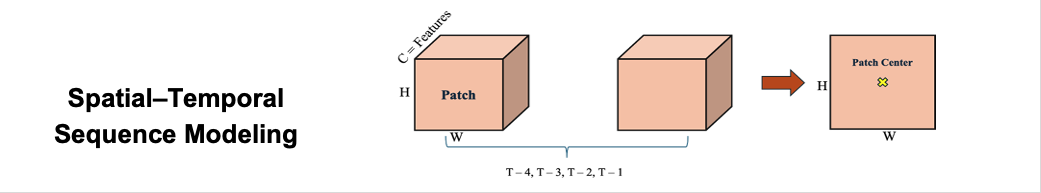

In [20]:
Image(filename=FIGURES_DIR / "spatial-Temporal.png")

# Insights and discussions

## Insights

1. **Progressive Feature Enrichment Improves Performance**  
   Across all models, adding **previous burn history (PBH)** consistently improved recall and overall F1-score, confirming that spatial memory of past fires is a strong predictor in the Pantanal. The largest jump occurred when incorporating **AlphaEarth embeddings**, which significantly enhanced both precision and recall—suggesting these embeddings capture critical spatial–temporal patterns not present in raw environmental variables.

2. **Shift in Predictive Drivers with AlphaEarth Embeddings**  
   In the **Basic Features** model, static environmental variables—**elevation (`dem`)**, **soil moisture (`swvl1`)**, and **surface pressure (`sp`)**—dominated feature importance, highlighting the role of topography and hydrology in baseline fire risk. After adding embeddings and PBH, the top predictors shifted toward **spectral bands** (e.g., `band_14`, `band_23`, `band_46`), embedding-derived variables (`embed_min`), and **lag_5** (burn history), reflecting the added value of fine-scale Earth observation and temporal context.

3. **Model Performance Hierarchy**  
   - **XGBoost** achieved the highest precision, recall, and F1-scores across all feature sets, outperforming RF and TabNet in nearly every scenario.  
   - **Random Forest** remained competitive for simpler feature sets but plateaued in performance gains as complexity increased.  
   - **TabNet** results are pending, though its attention-based design suggests it may excel in leveraging embeddings for nuanced feature interactions.

4. **Feature Importance Patterns Across Models**  
   For RF and XGBoost without embeddings, **burn history**, **elevation (dem)**, **soil moisture (`swvl1`)**, and **land cover type** were consistently among the top predictors. With embeddings, feature importance rankings shifted toward spectral–temporal indicators, underscoring their ability to capture landscape condition and climatic gradients relevant to fire ignition and spread.



# Conclusions

1. **Progressive Feature Enrichment Improves Prediction**  
   - Adding **previous burn history (PBH)** consistently improved recall and overall F1-scores.  
   - Incorporating **AlphaEarth embeddings** provided the biggest gains, improving both precision and recall by capturing spatial–temporal patterns not present in raw climate and land-cover data.  

2. **Drivers of Burn Prediction Shift with Embeddings**  
   - Without embeddings, **topography (DEM)**, **soil moisture (swvl1)**, and **surface pressure (sp)** were dominant predictors.  
   - With embeddings, the importance shifted toward **spectral bands** and lagged burn features, highlighting how fine-scale EO data adds context to fire risk.  

3. **Model Hierarchy**  
   - **XGBoost** outperformed Random Forest and TabNet across all feature sets, offering the best tradeoff of precision and recall.  
   - **Random Forest** was competitive on simple features but plateaued with added complexity.  
   - **TabNet** showed potential for leveraging embeddings but lagged behind tree-based methods in current runs.  

4. **Spatiotemporal Modeling Advantage**  
   - The ConvLSTM model demonstrated its ability to capture **burn progression over time and space**, an improvement over pixel-day independent models.  
   - This highlights the need for spatiotemporal approaches in operational wildfire forecasting.  

5. **Implications for Fire Management**  
   - Models confirm the critical role of **fire memory (previous burns)** in predicting new ignitions.  
   - Incorporating **EO embeddings and sequence models** can enhance early warning systems and resource allocation, supporting proactive wildfire management in the Pantanal.  


# References

[1] [Carbon Brief](https://www.carbonbrief.org/climate-change-made-the-supercharged-2024-pantanal-wildfires-40-more-intense/). (2024, August 8).

[2] [World Weather Attribution](https://www.worldweatherattribution.org/hot-dry-and-windy-conditions-that-drove-devastating-pantanal-wildfires-40-more-intense-due-to-climate-change/). (2024, August 8).

[3] Masrur, A., & Yu, M. (2023). [*ConvLSTM networks for predicting and physically interpreting wildfire spread*](https://www.sciencedirect.com/science/article/abs/pii/B9780323917377000098). In *Artificial Intelligence in Earth Science* (pp. 119–156). Elsevier.

[4] Masrur, A., Yu, M., & Taylor, A. (2024). [*Capturing and interpreting wildfire spread dynamics: attention-based spatiotemporal models using ConvLSTM networks*](https://www.sciencedirect.com/science/article/pii/S1574954124003029). *Ecological Informatics, 82*, 102760.
